# Mise en évidence de l'effet de site

## Modules

In [142]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import os
from glob import glob

In [53]:
from obspy import read, read_inventory, UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.invsim import estimate_wood_anderson_amplitude
from obspy.core.event import read_events

## Outils pour l'analyse de données

In [5]:
client = Client("RESIF") # Réseau français

In [393]:
stations = {'WALT', 'HOHE', 'CIEL', 'WLS', 'NEEW', 'SZBH', 'STR', 'ILLF', 'ZELS'}
direction_plans = {"horizontale" : ("N", "E", "W", "S", "1", "2",), "verticale" : ("Z",)}
path = 'data/'
filename = 'data'
latitude_plaine, longitude_plaine = (47.3, 49.1), (6.5, 8.5) # latmin latmax longmin longmax
coords_plaine = {"latitude": (47.3, 49.1), "longitude": (6.5, 8.5)}
coords = {
    "minlatitude": 47.3,
    "maxlatitude": 49.1,
    "minlongitude": 6.5,
    "maxlongitude": 8.5,
}
url_query = "https://api.franceseisme.fr/fdsnws/event/1/query?{query}/"
url_event = "https://renass.unistra.fr/fr/evenements/{event_id}/"

In [7]:
# Séisme induit de Strasbourg de référence
starttime = UTCDateTime(2021,6,26,3,0,0)
duration = 3*60
location = (48.66, 7.82)

### Récupération des données/métadonnées des stations
Note : Les données semblent disponible qu'à partir de 2011.

In [8]:
def get_S(name, starttime=starttime, duration=duration):
    return client.get_waveforms("FR", name, "00", "HH*", starttime, starttime + duration)

In [9]:
def get_inventory(name, starttime=starttime, duration=duration):
    return client.get_stations(network="FR", station=name, channel="HH*", starttime=starttime, level="response")

In [10]:
def download_S(stations=stations, path=path, filename=filename, extension='.miniseed', starttime=starttime, duration=duration):
    S = Stream()
    for station in stations:
        try:
            S += get_S(station, starttime=starttime, duration=duration)
        except Exception:
            pass
    if len(S) == 0:
        raise ValueError('Cannot save 0 traces.')
    else:
        S.write(os.path.join(path, filename + extension), format="MSEED")
    return S

In [11]:
def download_inventory(stations=stations, path=path, filename=filename, extension='.xml', starttime=starttime, duration=duration):
    inventory = get_inventory(','.join(stations), starttime=starttime, duration=duration)
    inventory.write(os.path.join(path, filename + extension), format='STATIONXML')
    return inventory

In [12]:
def download(stations=stations, path=path, filename=filename, starttime=starttime, duration=duration):
    return (download_S(stations, path=path, filename=filename, starttime=starttime, duration=duration), 
            download_inventory(stations, path=path, filename=filename, starttime=starttime, duration=duration))

In [13]:
def load(path=path, filename=filename):
    return read(os.path.join(path, f'{filename}.miniseed')), read_inventory(os.path.join(path, f'{filename}.xml'))

### Analyse du signal

#### Calculs préliminaires sur les traces

In [14]:
def filtration(T):
    T.detrend("demean")
    T.taper(0.1)
    T.filter("bandpass", freqmin=1, freqmax=5)

#### Utilisation des métadonnées

In [15]:
def gain(T, inventory):
    chinv = inventory.select(channel=T.id.split('.')[-1])[0][0][0]
    gain = chinv.response.instrument_sensitivity.value
    return gain

In [16]:
def dist_epi(station, inventory, location=location):
    stinv = inventory.select(station=station)[0][0]
    distance = gps2dist_azimuth(stinv.latitude, stinv.longitude, location[0], location[1])[0]
    return distance

#### Amplitude maximale d'une trace

In [17]:
def amplitude_brut(T):
    t = T.data
    amplitude = max(abs(t))
    return amplitude

#### Fréquences

In [18]:
def spectre(T):
    TFZ = np.fft.fft(T.data)/gain(T, inventory)
    f = np.fft.fftfreq(len(TFZ),T.stats.delta)

    plt.plot(f, np.abs(TFZ), label=T.id)
    plt.xlabel('frequence (Hz)')
    plt.ylabel('amplitude (m/s)')
    plt.xlim((0,10))
    plt.legend()

In [19]:
def freq_max(T):
    TFZ = np.fft.fft(T.data)/gain(T, inventory)
    f = np.fft.fftfreq(len(TFZ),T.stats.delta)
    amplitude = np.argmax(TFZ)
    frequence = np.abs(f[amplitude])
    return frequence

#### Magnitude locale
https://www.resif.fr/ressources/sismologie/dictionnaire-des-termes-de-sismologie/

In [20]:
def magnitude_locale(amplitude, distance):
    """
    amplitude : m/s
    distance : m
    """
    a = 0.018
    b = 2.17
    return np.log10(amplitude * 1000) + a * distance/1000 + b

### Généralisation pour plusieurs traces et stations

#### Récolte des données avec analyse

In [47]:
def get_amplitudes(S, inventory, location=location):
    """récolte les données sous forme de dictionnaire"""
    amplitudes = {}
    for T in S:
        amplitude = amplitude_brut(T)/gain(T, inventory)
        station = T.id.split('.')[1]
        direction = T.id[-1]
        
        try:
            amplitudes[station]
        except KeyError:
            amplitudes[station] = {"horizontale": [], "verticale": []}
            
        for plan in direction_plans:
            if direction in direction_plans[plan]:
                amplitudes[station][plan].append(amplitude)
                
        T.stats.distance = dist_epi(station, inventory=inventory, location=location)
    # np.average(amplitudes_values[plan])
    return amplitudes

In [45]:
def get_df(S, inventory, location=location):
    """récolte les données sous forme de tableau pd.DataFrame"""
    data = get_amplitudes(S, inventory, location)
    df = pd.DataFrame.from_dict(data=data, orient='index')
    df.index.name = 'station'
    df['nom'] = df.apply(lambda row: inventory.select(station=row.name)[0][0].site.name, axis=1)
    df['horizontale'] = df['horizontale'].apply(np.average)
    df['verticale'] = df['verticale'].apply(np.average)
    df['distance'] = df.apply(lambda row: dist_epi(row.name, inventory=inventory, location=location), axis=1)
    df['frequence'] = df.apply(lambda row: freq_max(S.select(station=row.name, component='Z')[0]), axis=1)
    df['Ml'] = df.apply(lambda row: magnitude_locale(max(row.horizontale, row.verticale), row.distance), axis=1)
    df['Mlv'] = df.apply(lambda row: magnitude_locale(row.verticale, row.distance), axis=1)
    df = df.sort_values(by='distance')
    return df

#### Exemple sur le séisme de référence

In [483]:
folder_name = "seismes"
local_path = os.path.join(path, folder_name)

In [484]:
# download(stations=stations, path=local_path, starttime=starttime, duration=duration) # télécharger les données dans le dossier séisme
S, inventory = load(path=local_path) # charge les données
Skeep = S.copy() # copie les données
filtration(S) # filtre les données
df_seisme = get_df(S, inventory)

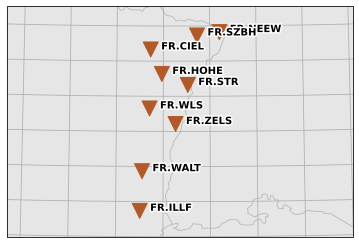

In [485]:
ax = inventory.plot(projection="local")

In [486]:
df_seisme

horizontale  verticale         nom       distance  frequence  \
station                                                                 
STR         0.002694   0.000554  Strasbourg    9839.470651   2.983333   
HOHE        0.000203   0.000180   Hohengœft   24730.920314   3.361111   
CIEL        0.000246   0.000121   Vacanciel   38657.037798   1.388889   
NEEW        0.000084   0.000066   Neewiller   38969.213465   2.449932   
ZELS        0.000065   0.000068    Zelsheim   42143.981841   1.649954   
WALT        0.000049   0.000097  Westhalten   87090.321688   1.366629   
ILLF        0.000048   0.000028    Illfurth  116453.372036   1.749951   

               Ml       Mlv  
station                      
STR      2.777480  2.090549  
HOHE     1.922862  1.869979  
CIEL     2.257550  1.949050  
NEEW     1.796989  1.689643  
ZELS     1.763280  1.763280  
WALT     2.724182  2.724182  
ILLF     2.943513  2.718585

Text(0.5, 1.0, 'Séisme induit de Strasbourg enregistré sur les stations alsaciennes')

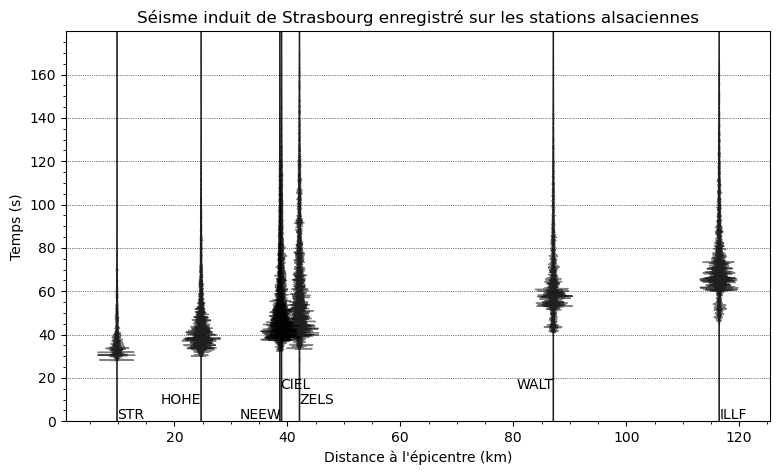

In [534]:
# S.plot(type='section') # simple plot
fig = plt.figure()
fig.set_size_inches(8, 5)
fig.set_dpi(100)
S.plot(type='section', fig=fig)
k = 0
for row in df_seisme.iterrows():
    T = S.select(station=row[0])[0]
    fig.axes[0].text(T.stats.distance/1e3, 1+(k%3)*7, s=T.stats.station, rotation=0, ha=("right" if k%2 else "left"))
    k += 1
plt.xlabel("Distance à l'épicentre (km)")
plt.ylabel("Temps (s)")
fig.axes[0].set_title('Séisme induit de Strasbourg enregistré sur les stations alsaciennes')

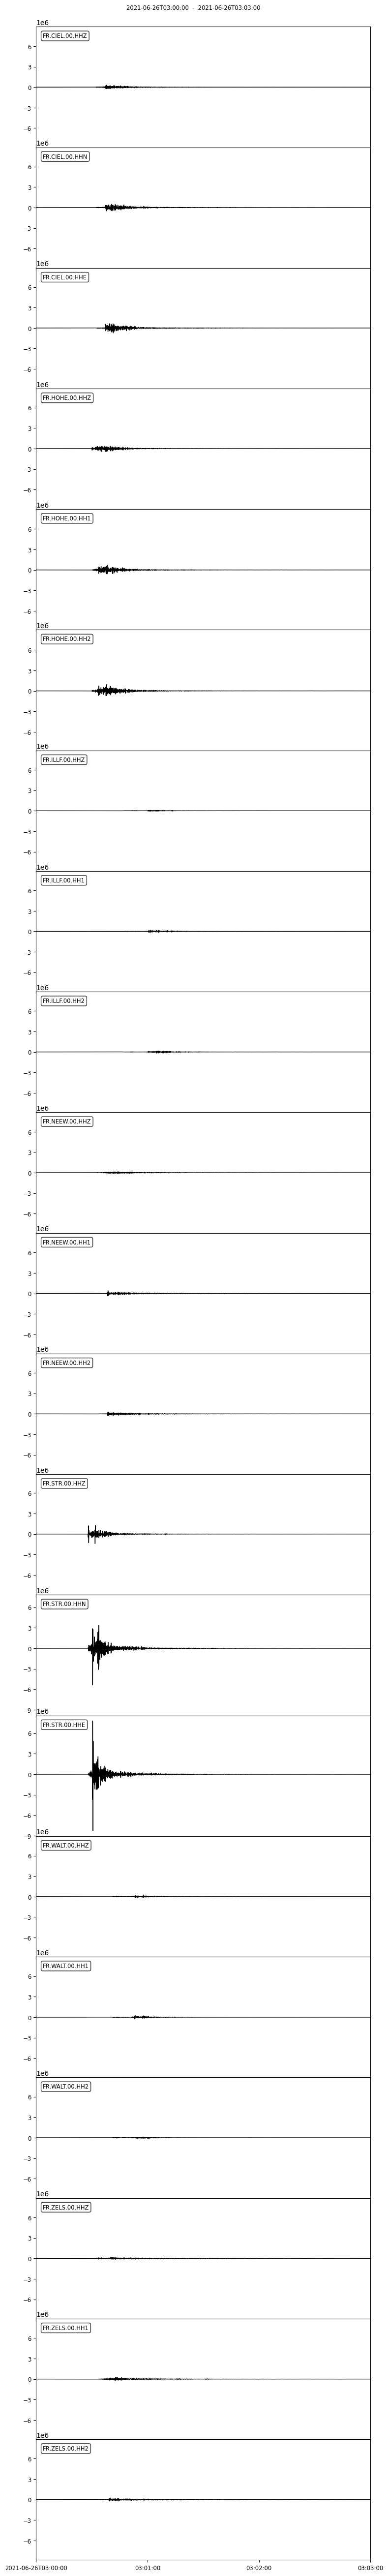

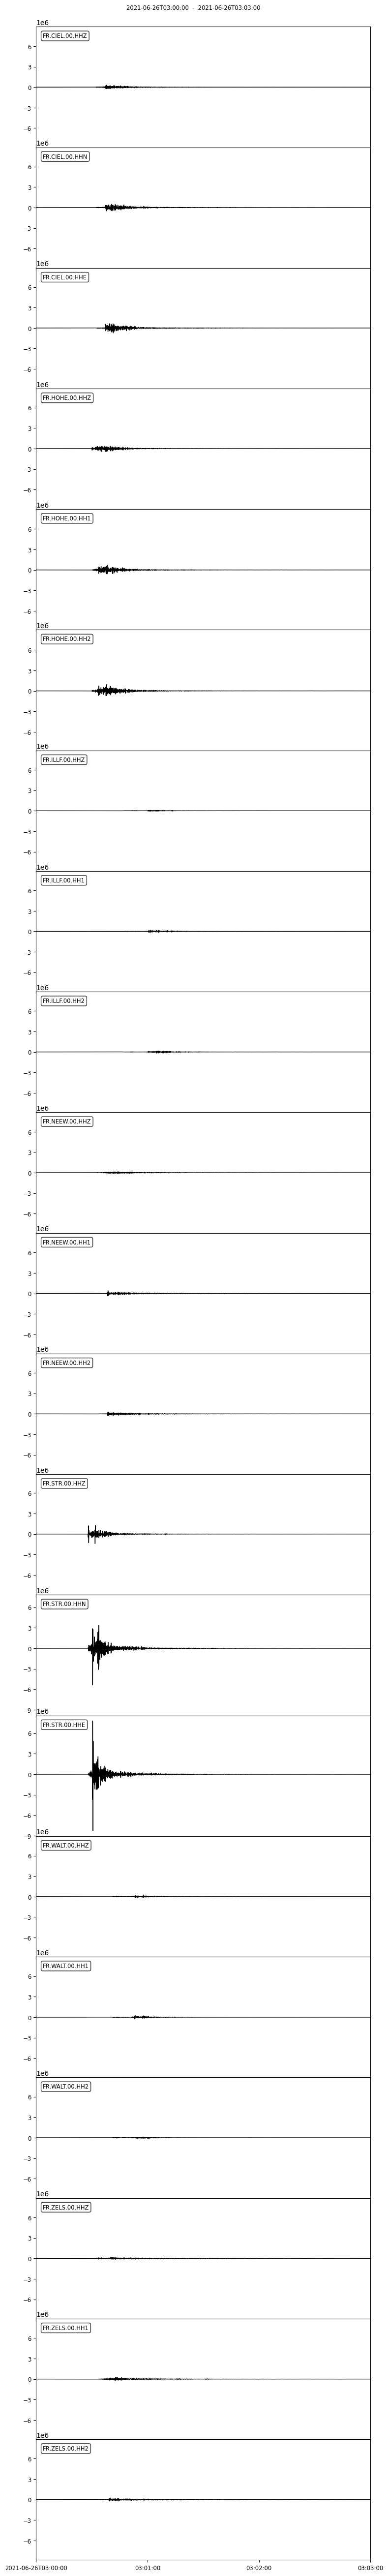

In [262]:
S.plot()

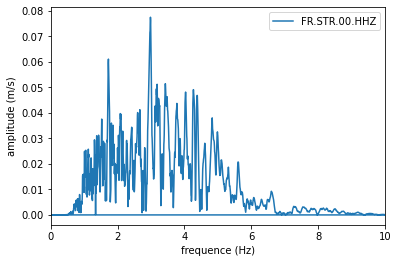

In [26]:
T = S.select(station='STR', component='Z')[0]
spectre(T)

## Utilisation de ces outils pour la mise en évidence de l'effet de site

In [521]:
def get_date(data):
    return UTCDateTime(data.annee, data.mois, data.jour, data.heure, data.minute, 0)

def get_datestr(data, strf="%Y-%m-%d"):
    return get_date(data).strftime(strf)
    
def get_folder(row, local_path):
    return os.path.join(local_path, get_datestr(row[1]))

def get_link(data, url=url_query, duration=5*60, coords=None, mag_min=2.0):
    date = get_date(data)
    arguments = {
        "starttime": date,
        "endtime": date+duration,
        "minmagnitude": mag_min,
        "orderby": "magnitude-asc",
    }
    if coords:
        for key in coords:
            arguments[key] = coords[key]
    query = '&'.join(f'{key}={arguments[key]}' for key in arguments if arguments[key] is not None)
    return url.format(query=query)

In [522]:
to_float = lambda char: float(char.replace(',', '.'))

def download_seismes(df, local_path, duration=2*60, skip=True):
    """Télécharge les données des capteurs des séismes, les analyse, et les stock dans un dossier"""
    for row in df.iterrows():
        data = row[1]
        starttime = UTCDateTime(data.annee, data.mois, data.jour, data.heure, data.minute, 0)
        # location = (to_float(data.lat), to_float(data.long))
        # Mref = float(to_float(data.Mref))
        folder = get_folder(row, local_path=local_path)
        try:
            os.makedirs(folder)
            print(f'Created folder {folder}')
        except FileExistsError:
            print(f'Folder {folder} already exists')
            if skip:
                file = os.path.join(folder, 'data.miniseed')
                if os.path.isfile(file):
                    print(f'Skipping : File {file} already exists')
                    continue
        try:
            S, inventory = download(stations=stations, path=folder, starttime=starttime, duration=duration)
            print(f'Successfully downloaded {len(S)} traces')
        except ValueError:
            print(f'No traces found')

In [535]:
def process_seismes(df, local_path, coords=None):
    for row in df.iterrows():
        folder = get_folder(row, local_path=local_path)
        try:
            event = read_events(os.path.join(folder, 'event.xml'))[0]
            print(f'Found event')
        except FileNotFoundError:
            link = get_link(row[1], coords=coords)
            print(f'Searching for event {link}')
            events = read_events(link)
            if len(events) == 0:
                print(f'Event not found, skipping')
                continue
            event = events[0]
            event.write(os.path.join(folder, 'event.xml'), format="QUAKEML")
            print(f'Downloaded event')
        title = f'{event.event_descriptions[0].text} ({get_datestr(row[1], "%d/%m/%Y")})'
        print(title)
        print(url_event.format(event_id=event.resource_id.id.split('/')[-1]))
        try:
            S, inventory = load(path=folder)
            print(f'Found files in {folder}')
        except FileNotFoundError:
            print(f'Files in {folder} not found')
            continue
        filtration(S)
        df_seisme = get_df(S, inventory, location=(to_float(row[1].lat), to_float(row[1].long)))
        df_seisme.to_csv(os.path.join(folder, 'output.csv'), sep=';')
        # S.plot(type='section', outfile=os.path.join(folder, 'output.png'))
        fig = plt.figure()
        fig.set_size_inches(8, 5)
        fig.set_dpi(100)
        fig.patch.set_facecolor('white')
        S.plot(type='section', fig=fig, outfile=os.path.join(folder, 'raw_output.png'))
        k = 0
        for row_seisme in df_seisme.iterrows():
            T = S.select(station=row_seisme[0])[0]
            fig.axes[0].text(T.stats.distance/1e3, 1+(k%3)*7, s=T.stats.station)
            k += 1
        fig.axes[0].set_title(title)
        plt.xlabel("Distance à l'épicentre (km)")
        plt.ylabel("Temps (s)")
        fig.savefig(os.path.join(folder, 'output.png'), dpi=300)
        print(f'Processed graph')

In [524]:
def compare(local_path, stations_comp=('ILLF', 'WLS'), column='verticale'):
    """Compare plusieurs stations par rapport à différent facteurs sur différents séismes"""
    folders = [os.path.join(local_path, f) for f in os.listdir(local_path) if os.path.isdir(local_path)]
    data = {station: [] for station in stations_comp}
    skipped = 0
    for folder in folders:
        # S, inventory = load(path=folder, filename=filename)
        file = os.path.join(folder, f'output.csv')
        if os.path.exists(file):
            df_seisme = pd.read_csv(file, sep=';', index_col='station')
            if not any(station not in df_seisme.index for station in stations_comp):
                for station in stations_comp:
                    data[station].append(df_seisme[column][station])
            else:
                skipped += 1
    print(f'Skipped {skipped} event(s)')
    return pd.DataFrame(data=data)

## Séismes proches

In [525]:
folder_name = "seismes_proches"
local_path = os.path.join(path, folder_name)

In [526]:
df = pd.read_csv(f'{local_path}.csv', sep=';', index_col=0)

In [527]:
df = df.sort_values(by=['annee', 'mois', 'jour', 'heure', 'minute'], ascending=False) # trier les séismes pour télécharger les plus récents en premier
df = df[df['annee'] > 2016] # capteurs tous éteins avant 2011 et beaucoup avant 2016
# df.sort_values(by=['Mref'])

In [528]:
df

annee  mois  jour  heure  minute    lat  long Mref
12   2021    10     2     18      49     48  7,08    3
4    2021     6    26      3       0  48,66  7,82  3,9
21   2021     5    26     13      48  48,66  7,82  2,7
19   2021     4    10      0      49  48,66  7,82  2,8
8    2021     1    22     18      33  48,66  7,82  3,3
18   2020    12     4     10      10  48,67  7,82  2,8
5    2020    12     4      5      59  48,66  7,81  3,6
30   2020    12     4      5      59  48,66  7,81  2,6
27   2020    10    28      4      39  48,66  7,79  2,7
10   2019    11    12     13      38  48,61  7,79    3
14   2019     6    10      9      54  48,25  7,26  2,9
6    2018     5     4     21      36  47,75  7,52  3,6

In [221]:
# download_seismes(df, local_path=local_path, duration=2*60)

Folder data/seismes_proches/2021-10-02 already exists
Skipping : File data/seismes_proches/2021-10-02/data.miniseed already exists
Folder data/seismes_proches/2021-06-26 already exists
Skipping : File data/seismes_proches/2021-06-26/data.miniseed already exists
Folder data/seismes_proches/2021-05-26 already exists
Successfully downloaded 27 traces
Created folder data/seismes_proches/2021-04-10
Successfully downloaded 24 traces
Created folder data/seismes_proches/2021-01-22
Successfully downloaded 27 traces
Created folder data/seismes_proches/2020-12-04
Successfully downloaded 27 traces
Folder data/seismes_proches/2020-12-04 already exists
Skipping : File data/seismes_proches/2020-12-04/data.miniseed already exists
Folder data/seismes_proches/2020-12-04 already exists
Skipping : File data/seismes_proches/2020-12-04/data.miniseed already exists
Created folder data/seismes_proches/2020-10-28
Successfully downloaded 24 traces
Created folder data/seismes_proches/2019-11-12
Successfully down

Found event
Earthquake of magnitude 3.0, near of Colmar (02/10/2021)
https://renass.unistra.fr/fr/evenements/fr2021hlyfex/
Found files in data/seismes_proches/2021-10-02
Processed graph
Found event
Induced of magnitude 3.9, near of Strasbourg (26/06/2021)
https://renass.unistra.fr/fr/evenements/fr2021gthfmw/
Found files in data/seismes_proches/2021-06-26
Processed graph
Found event
Induced of magnitude 2.7, near of Strasbourg (26/05/2021)
https://renass.unistra.fr/fr/evenements/fr2021gnnawk/
Found files in data/seismes_proches/2021-05-26
Processed graph
Found event
Induced of magnitude 2.8, near of Strasbourg (10/04/2021)
https://renass.unistra.fr/fr/evenements/fr2021gesgla/
Found files in data/seismes_proches/2021-04-10
Processed graph
Found event
Induced of magnitude 3.3, near of Strasbourg (22/01/2021)
https://renass.unistra.fr/fr/evenements/fr2021fqclrt/
Found files in data/seismes_proches/2021-01-22
Processed graph
Found event
Induced of magnitude 2.8, near of Strasbourg (04/12/20

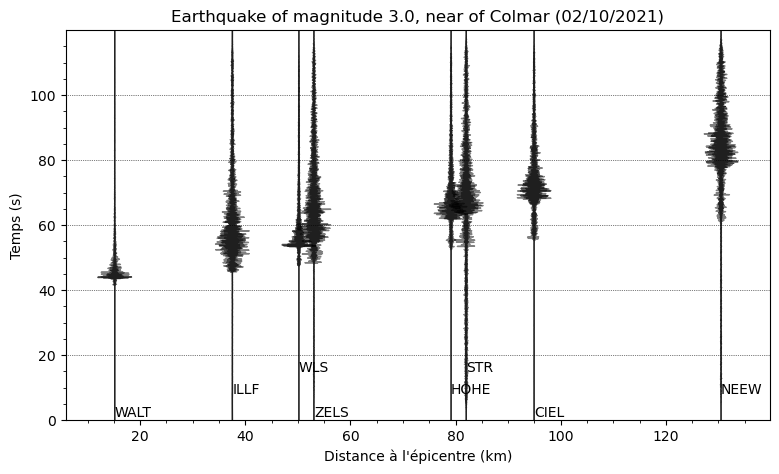

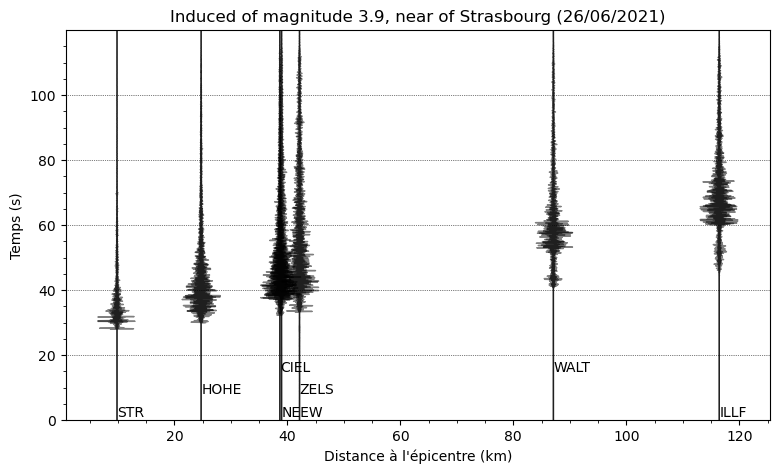

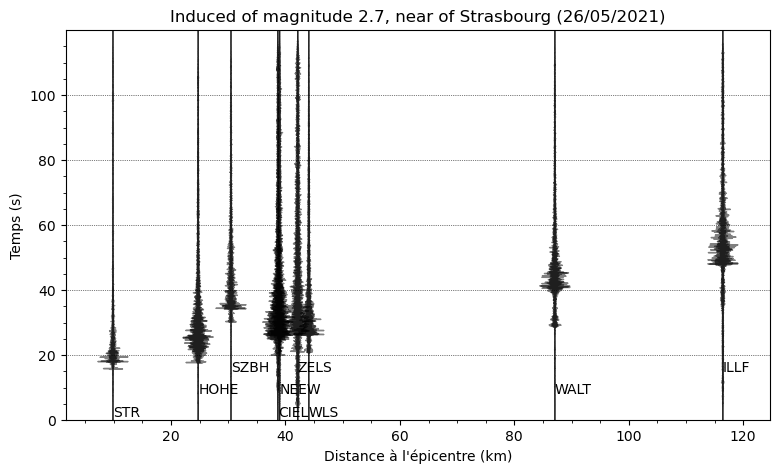

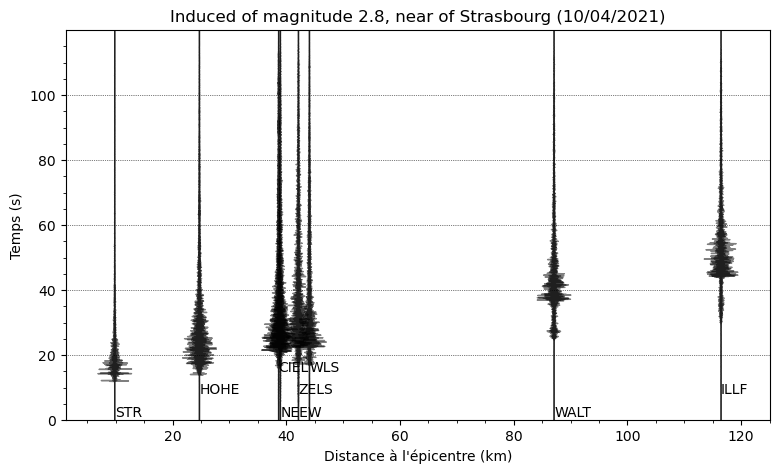

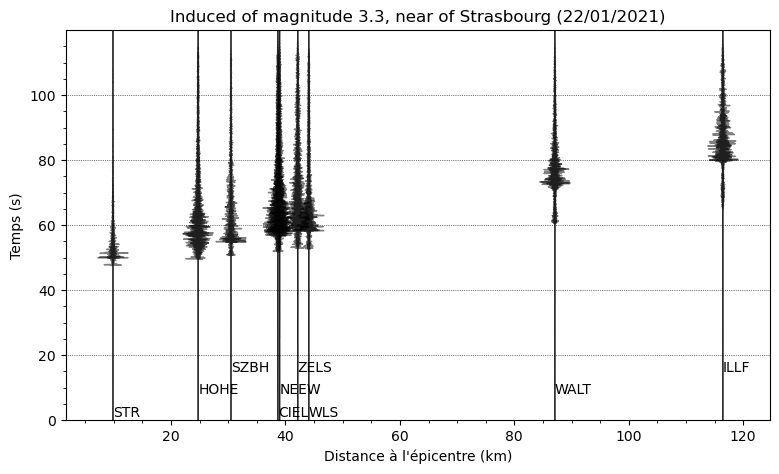

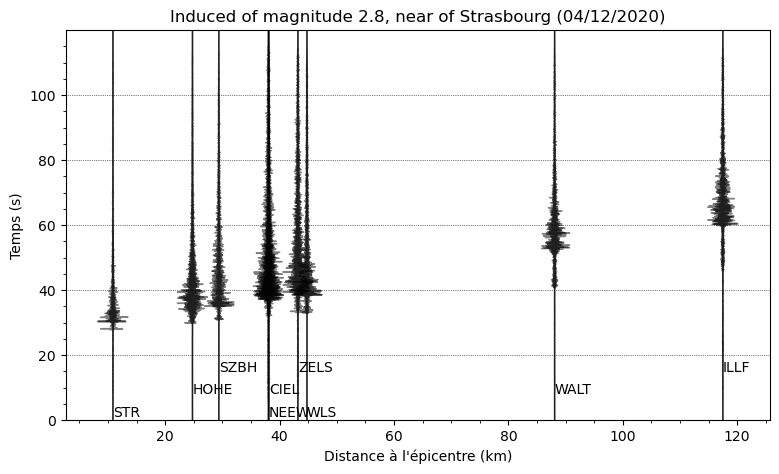

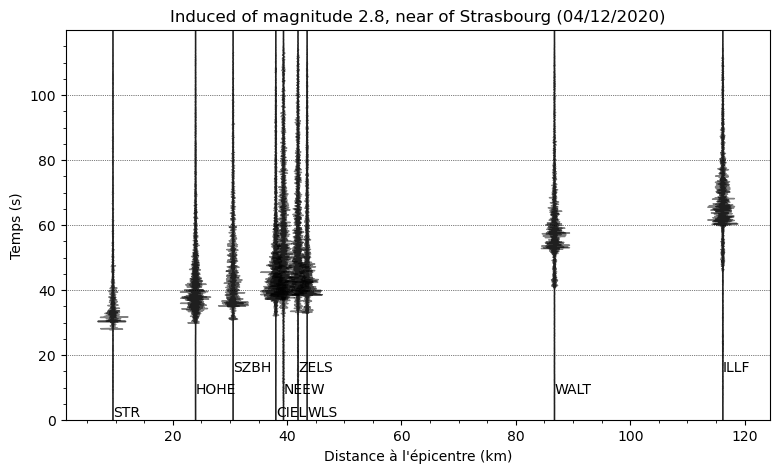

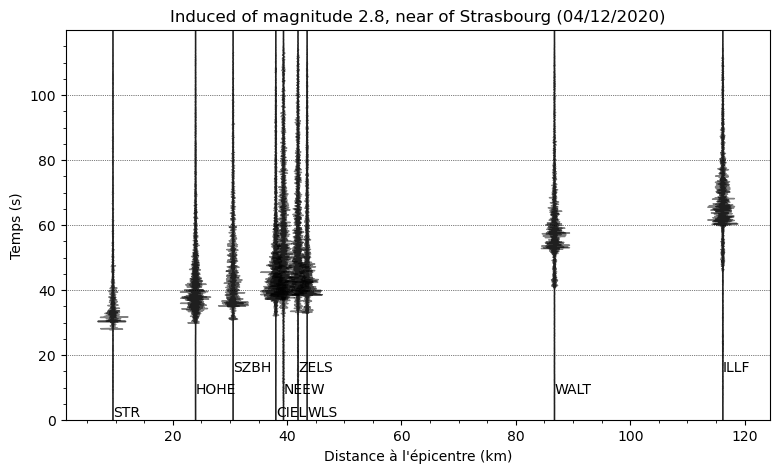

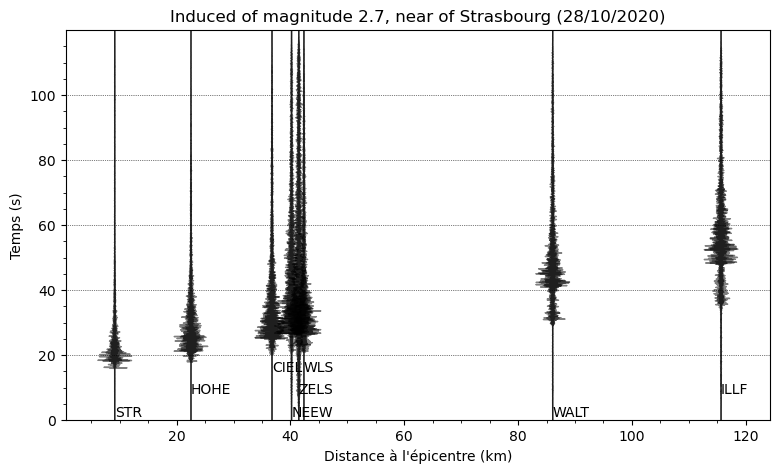

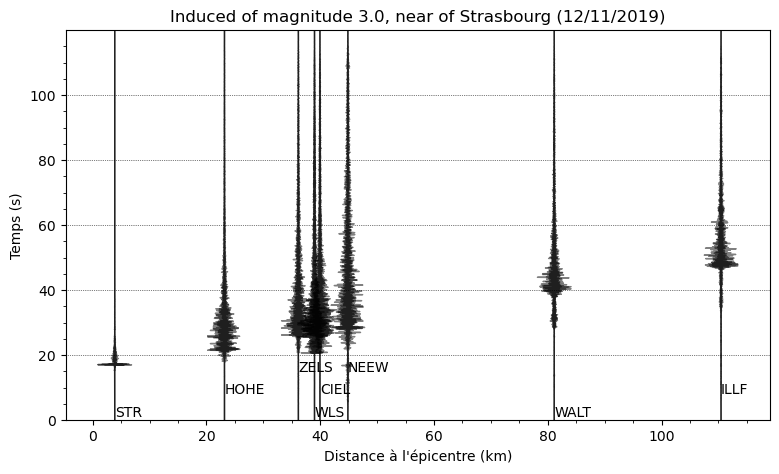

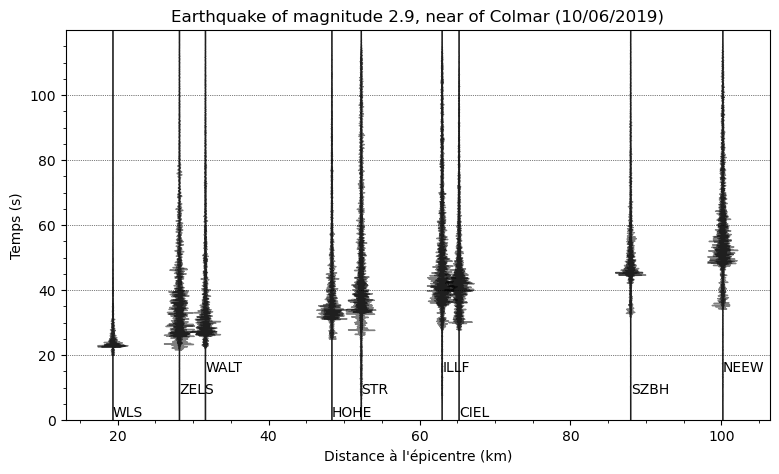

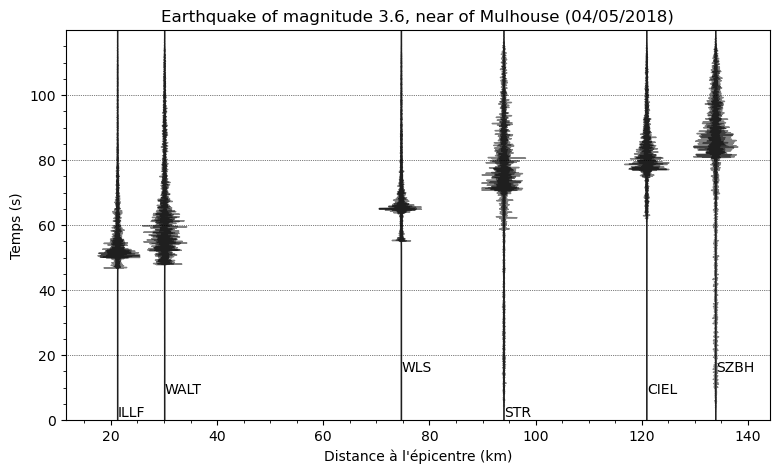

In [536]:
process_seismes(df, local_path=local_path, coords=coords)

In [340]:
df_amplitudes = compare(local_path=local_path)

Skipped 1 event(s)


In [341]:
df_amplitudes

ILLF           WLS
0  0.000005  2.636538e-06
1  0.000002  6.407402e-07
2  0.000020  3.624086e-06
3  0.000002  4.446225e-07
4  0.000009  1.222471e-06
5  0.000046  3.853055e-05
6  0.000003  4.895980e-07
7  0.000003  8.261380e-06
8  0.000004  7.676776e-07

In [342]:
values = df_amplitudes[df_amplitudes.columns[0]]/df_amplitudes[df_amplitudes.columns[1]]
np.average(values)

3.9172720094297406

Text(0, 0.5, 'Amplitude maximale')

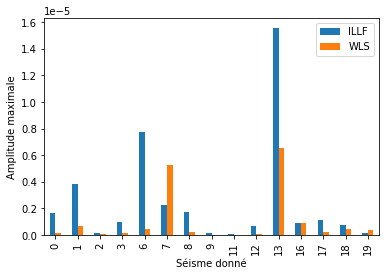

In [481]:
df_amplitudes.plot(kind='bar')
plt.xlabel('Séisme donné')
plt.ylabel('Amplitude maximale')

(-1.459674005352e-06, 4.8652245261492e-05)

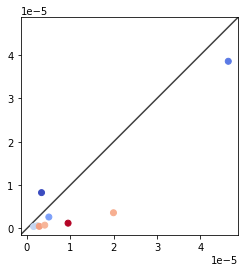

In [344]:
fig, ax = plt.subplots()
ax.scatter(df_amplitudes['ILLF'], df_amplitudes['WLS'], c=values, cmap=plt.cm.coolwarm)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

## Séismes loin

In [537]:
folder_name = "seismes_loin"
local_path = os.path.join(path, folder_name)

In [538]:
df = pd.read_csv(f'{local_path}.csv', sep=';', index_col=0)

In [539]:
df = df.sort_values(by=['annee', 'mois', 'jour', 'heure', 'minute'], ascending=False) # trier les séismes pour télécharger les plus récents en premier
# df.sort_values(by=['Mref'])

In [409]:
df

annee  mois  jour  heure  minute     lat    long Mref
0    2021    11     1     22       8    18,5  -62,32  5,2
1    2021     8    28     11      20    35,8   -3,31  5,2
2    2021     6     8      3      59   43,72   16,05    5
3    2021     4     6      8      54   45,06   17,15  5,1
4    2021     1    24     23      21   18,23   -63,9  5,4
6    2021     1     6     17       1   45,56   16,06  5,4
5    2020    12    30      5      26   45,68   15,91  5,1
7    2020    10     7     18      24   18,16  -64,38  5,6
8    2020    10     4     19      12   11.02  -61,51  5,2
9    2020     7     4      7      59   36,16    7,27  5,3
10   2019     9    21     14       4   41,64   19,66  5,4
11   2019     7    13      9      56    37,6    5,86  5,7
12   2019     2    16      4      35   35,51   -4,43  5,1
13   2019     1    14     23       4   44,58   11,91    5
15   2018     9     9     11      48  -11,69    41,3    5
14   2018     9     4     23       2   48,84   16,86  5,1
16   2018     8    21      5      47  -10,38    41,7  5,8
17   2018     8    16     18      19   42,22   15,13  5,5
18   2018     2    17     14      31   51,59   -3,78  5,1
20   2018     2     6     14      27   36,36    5,24  5,1
19   2018     2     3     12      53   44,17   17,25    5

In [412]:
# download_seismes(df, local_path=local_path, duration=15*60)

Created folder data/seismes_loin/2021-11-01
Successfully downloaded 24 traces
Created folder data/seismes_loin/2021-08-28
Successfully downloaded 21 traces
Created folder data/seismes_loin/2021-06-08
Successfully downloaded 24 traces
Created folder data/seismes_loin/2021-04-06
Successfully downloaded 24 traces
Created folder data/seismes_loin/2021-01-24
Successfully downloaded 27 traces
Created folder data/seismes_loin/2021-01-06
Successfully downloaded 27 traces
Created folder data/seismes_loin/2020-12-30
Successfully downloaded 27 traces
Created folder data/seismes_loin/2020-10-07
Successfully downloaded 21 traces
Created folder data/seismes_loin/2020-10-04
Successfully downloaded 24 traces
Created folder data/seismes_loin/2020-07-04
Successfully downloaded 24 traces
Created folder data/seismes_loin/2019-09-21
Successfully downloaded 24 traces
Created folder data/seismes_loin/2019-07-13
Successfully downloaded 27 traces
Created folder data/seismes_loin/2019-02-16
Successfully downloa

Found event
Earthquake of magnitude 5.2, near of Les Abymes (01/11/2021)
https://renass.unistra.fr/fr/evenements/fr2021hrqjdp/
Found files in data/seismes_loin/2021-11-01
Processed graph
Found event
Event of magnitude 5.2, near of Málaga (28/08/2021)
https://renass.unistra.fr/fr/evenements/fr2021hfgpzn/
Found files in data/seismes_loin/2021-08-28
Processed graph
Found event
Earthquake of magnitude 5.0, near of Sarajevo (08/06/2021)
https://renass.unistra.fr/fr/evenements/fr2021gpwyhc/
Found files in data/seismes_loin/2021-06-08
Processed graph
Found event
Earthquake of magnitude 5.1, near of Zagreb (06/04/2021)
https://renass.unistra.fr/fr/evenements/fr2021geagji/
Found files in data/seismes_loin/2021-04-06
Processed graph
Found event
Earthquake of magnitude 5.4, near of San Juan (24/01/2021)
https://renass.unistra.fr/fr/evenements/fr2021fqngwh/
Found files in data/seismes_loin/2021-01-24
Processed graph
Found event
Earthquake of magnitude 5.4, near of Zagreb (06/01/2021)
https://renas

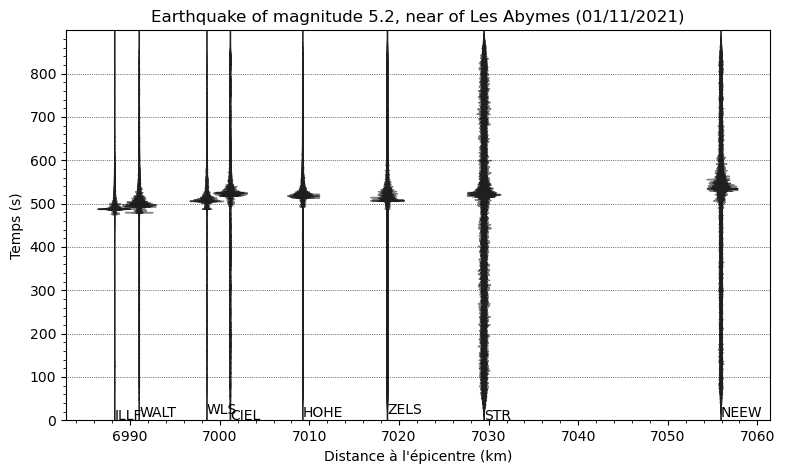

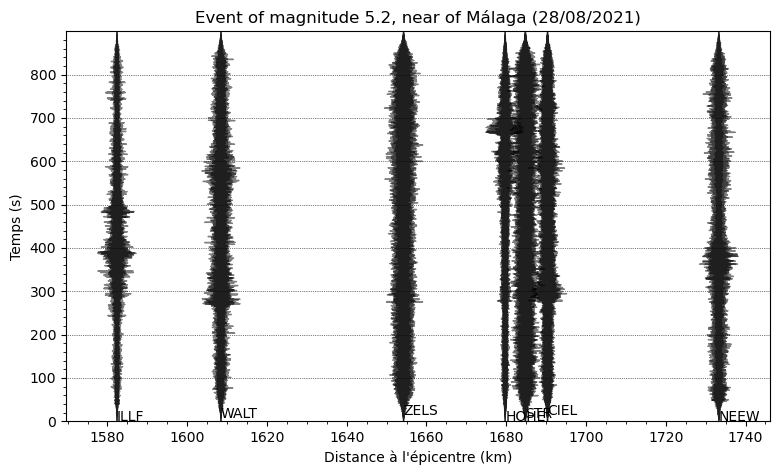

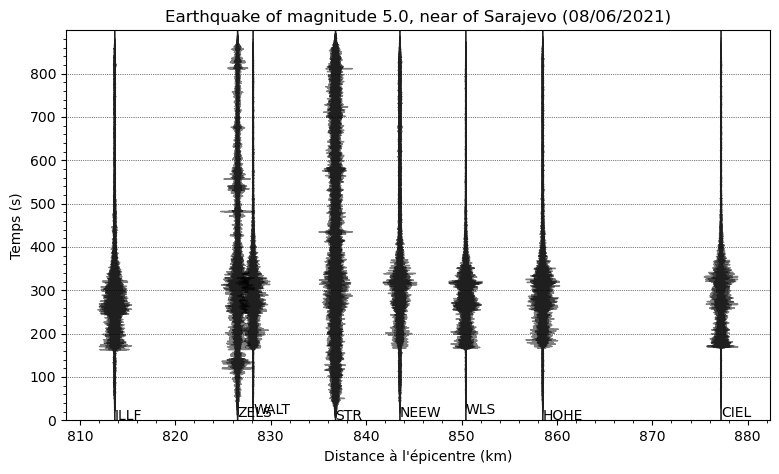

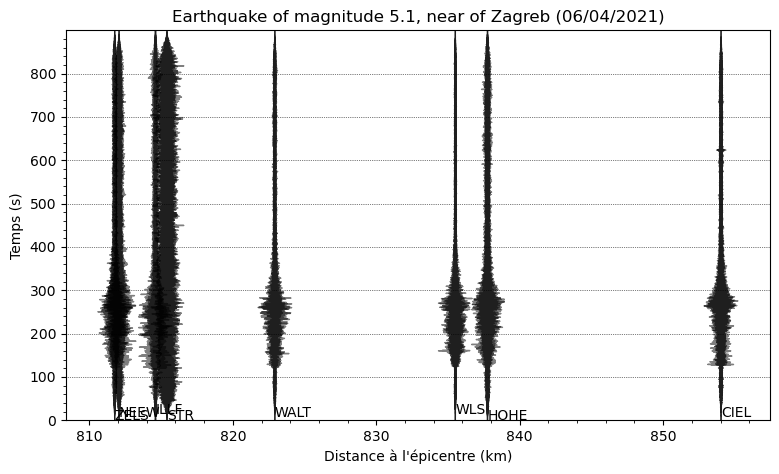

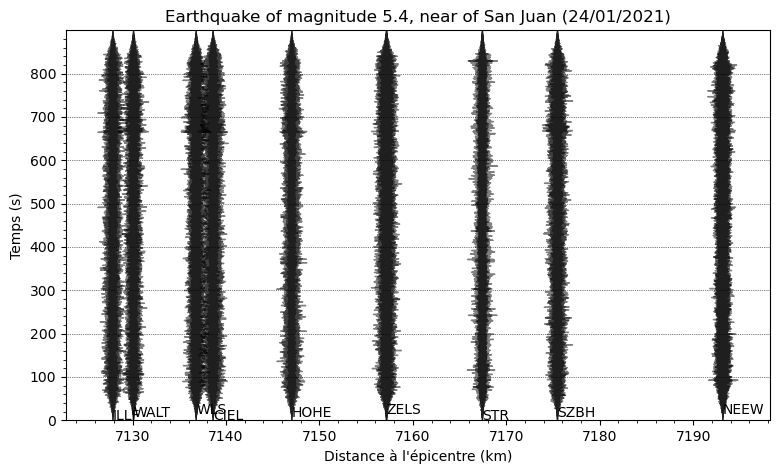

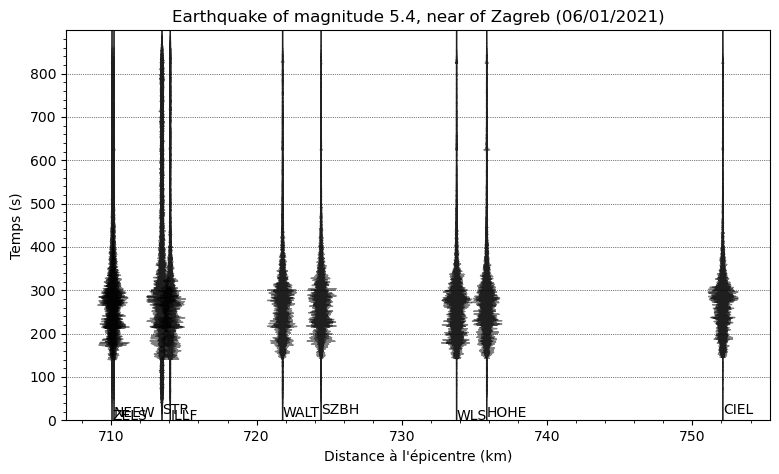

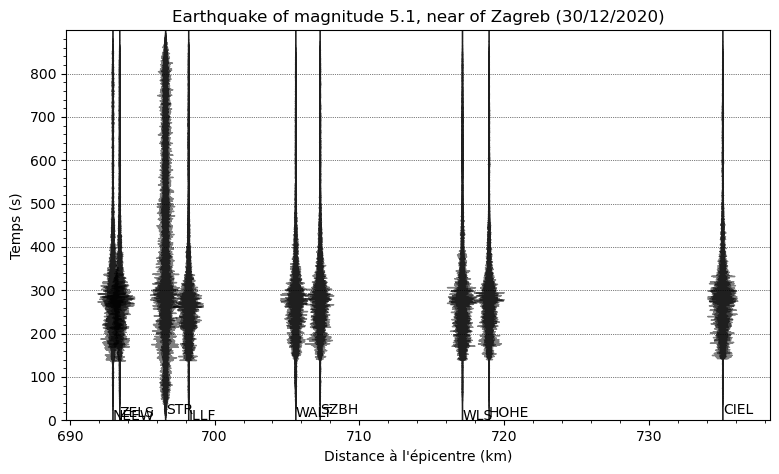

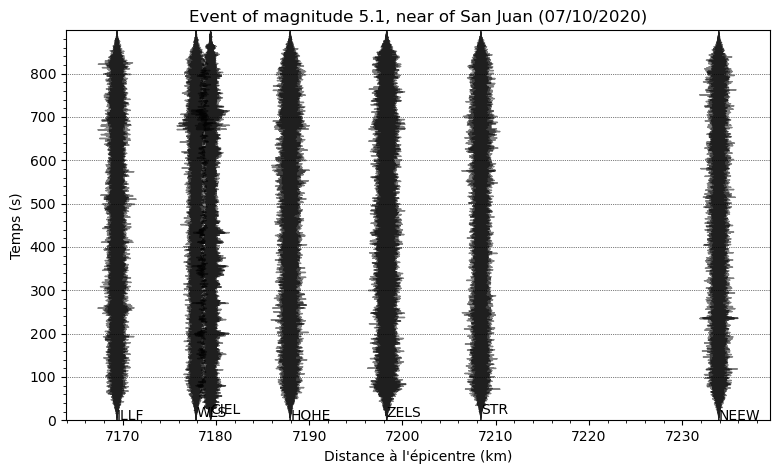

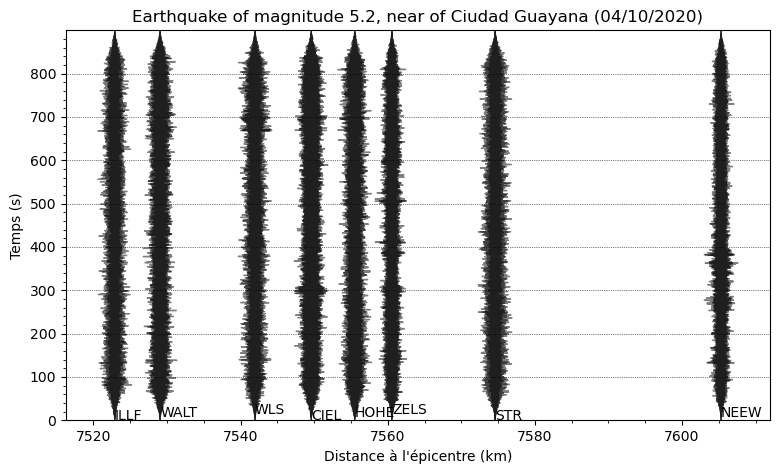

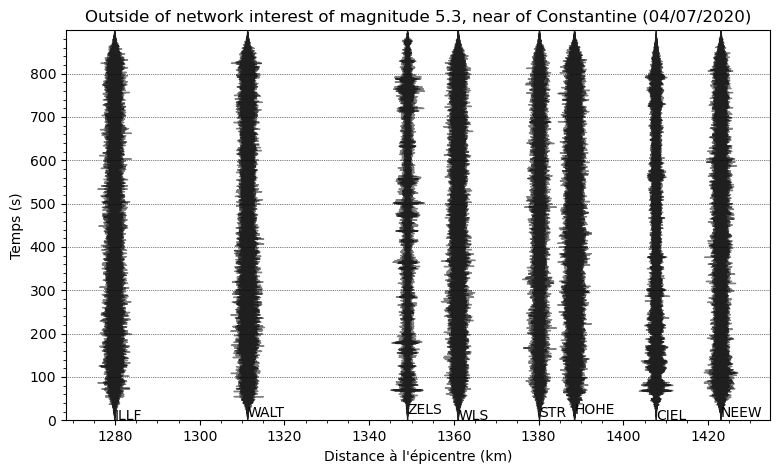

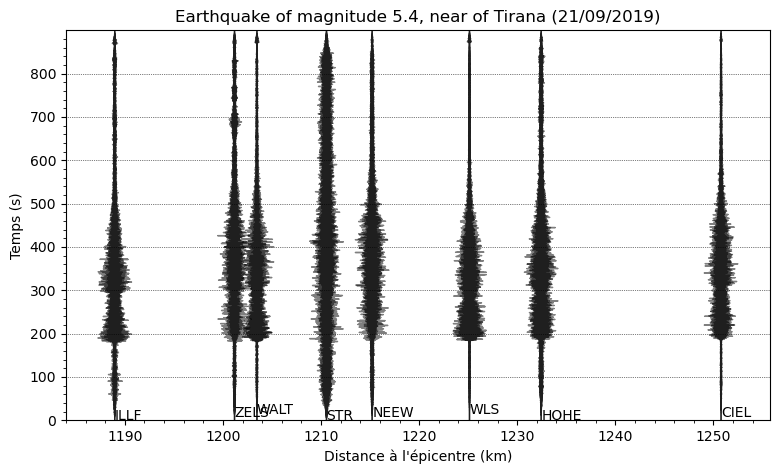

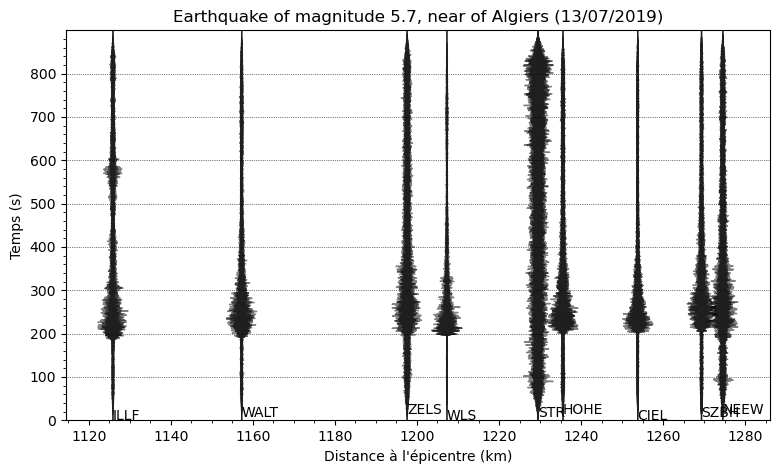

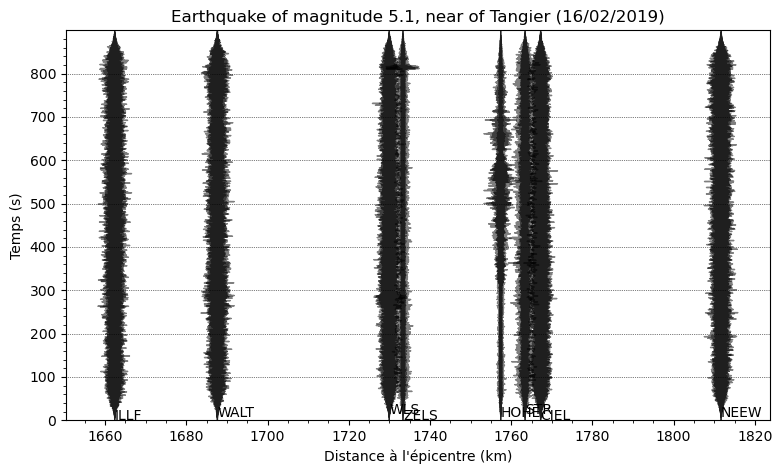

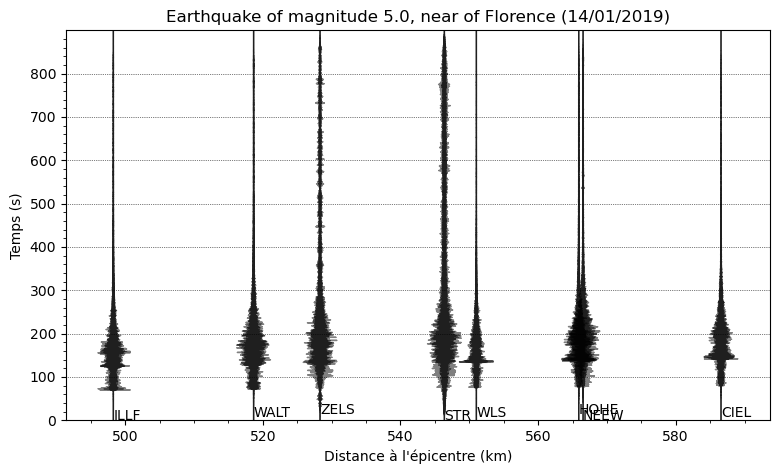

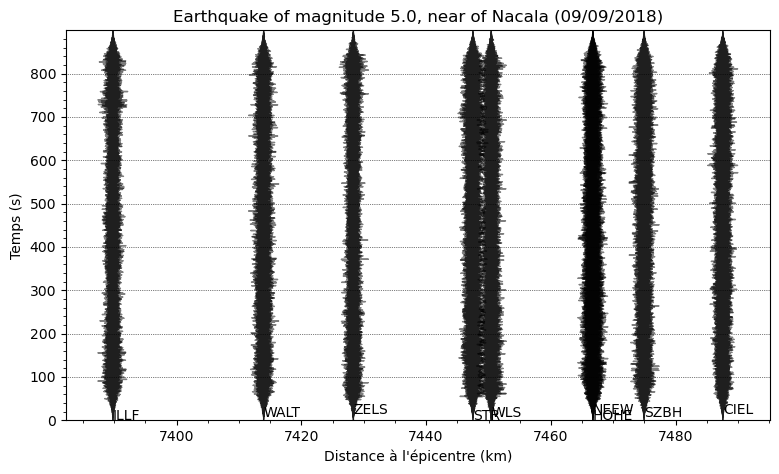

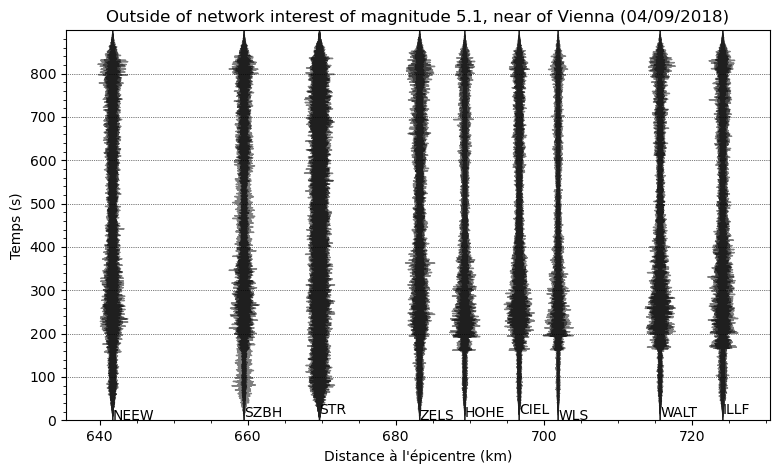

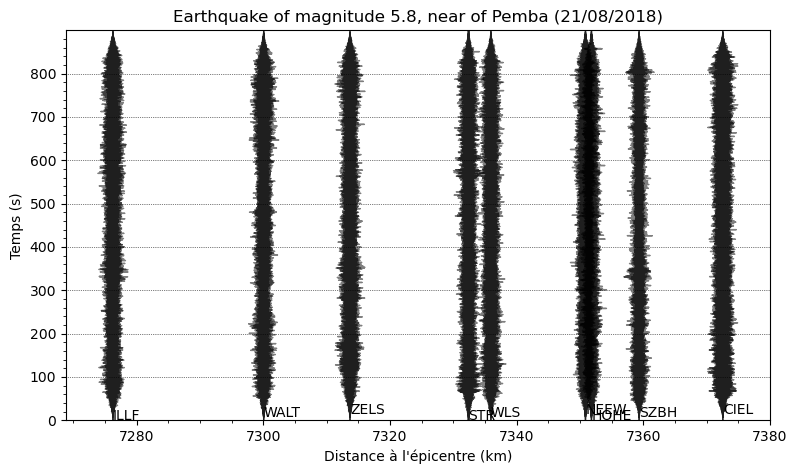

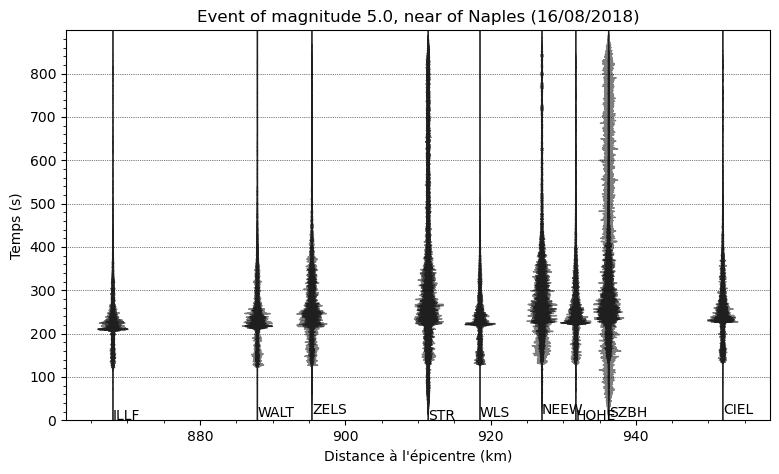

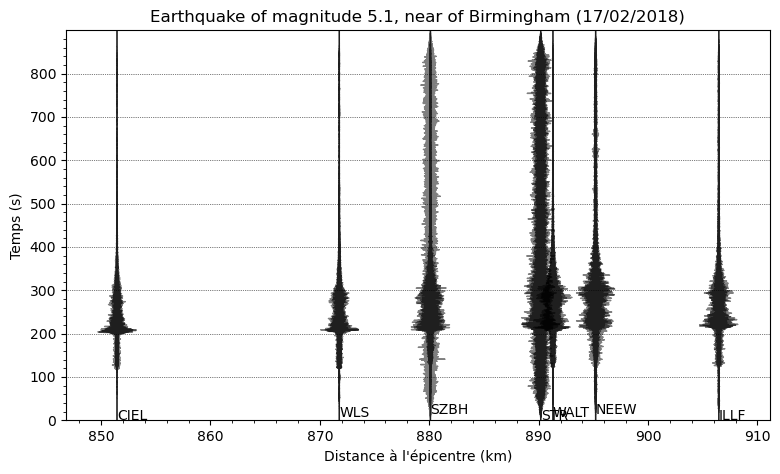

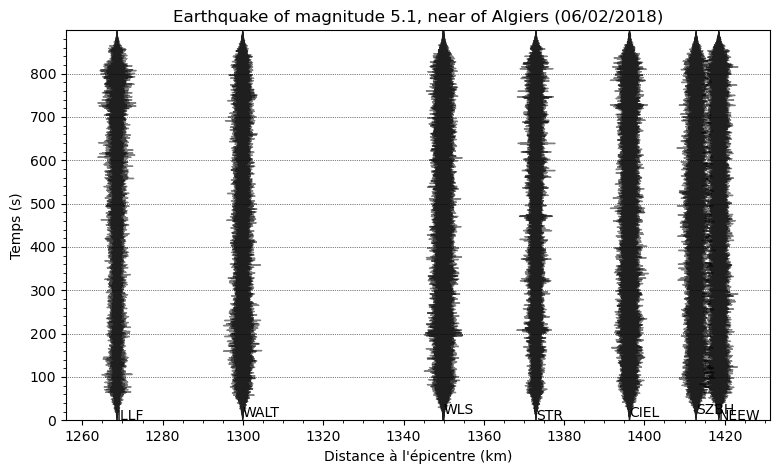

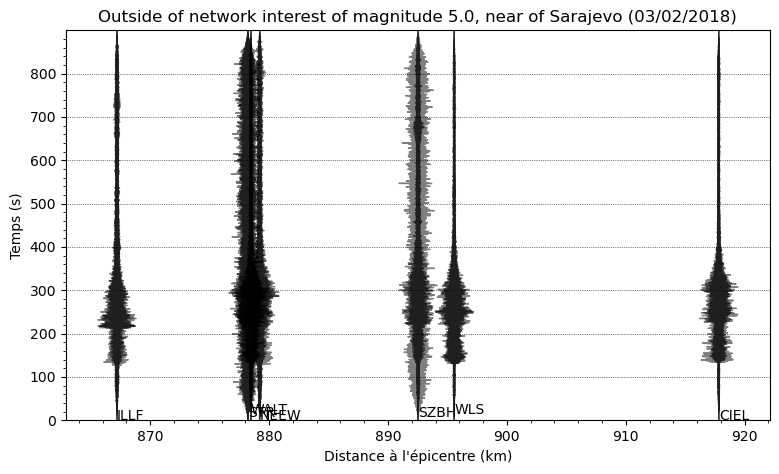

In [540]:
process_seismes(df, local_path=local_path, coords=None)

In [474]:
df_amplitudes = compare(local_path=local_path)

Skipped 1 event(s)


In [475]:
seuil = 1e-8
df_amplitudes = df_amplitudes[(df_amplitudes['ILLF'] > seuil) & (df_amplitudes['WLS'] > seuil)] # retirer les amplitudes trop faibles (qui mesurent du bruit plus que le séisme)

In [476]:
values = df_amplitudes[df_amplitudes.columns[0]]/df_amplitudes[df_amplitudes.columns[1]]
np.average(values)

4.7531767528664579

Text(0, 0.5, 'Amplitude maximale')

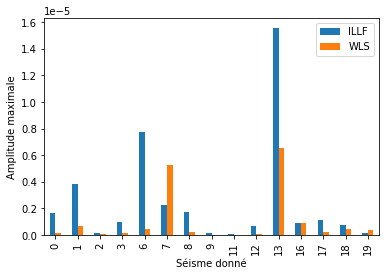

In [482]:
df_amplitudes.plot(kind='bar')
plt.xlabel('Séisme donné')
plt.ylabel('Amplitude maximale')

(-5.858737497760001e-07, 1.6338517436256e-05)

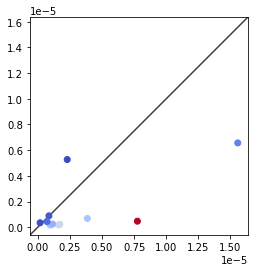

In [461]:
fig, ax = plt.subplots()
ax.scatter(df_amplitudes['ILLF'], df_amplitudes['WLS'], c=values, cmap=plt.cm.coolwarm)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# Commandes utiles

In [ ]:
os.makedirs(local_path)

In [239]:
df = pd.read_clipboard()

In [241]:
df.to_csv(f'{local_path}.csv', sep=';')